---
# Knowledge Graph Embedding(TransE) and User Query Embedding(BERT)

Checking if Tensorflow can access GPU.

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# Supress tf debugging messages and warnings. Only show tf errors.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
print('TensorFlow  version: {}'.format(tf.__version__))

# Get the GPU name
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow  version: 2.14.0
Found GPU at: /device:GPU:0


Installing AmpliGraph and other dependencies:

In [ ]:
# Required to visualize embeddings with tensorboard projector, comment out if not required!
! pip install --user tensorboard

# Required to plot text on embedding clusters, comment out if not required!
! pip install --user git+https://github.com/Phlya/adjustText

  Cloning https://github.com/Phlya/adjustText to /tmp/pip-req-build-8bbm75mi
  Running command git clone --filter=blob:none --quiet https://github.com/Phlya/adjustText /tmp/pip-req-build-8bbm75mi
  Resolved https://github.com/Phlya/adjustText to commit e474370b73b95c264da0f79124e95fdc4a5b2dd2
  Preparing metadata (setup.py) ... done


In [ ]:
! pip install ampligraph

In [ ]:
# All imports used in this tutorial

import ampligraph
import numpy as np
import pandas as pd
import tensorflow as tf

from ampligraph.evaluation import train_test_split_no_unseen, mr_score, mrr_score, hits_at_n_score
from ampligraph.discovery import query_topn, discover_facts, find_clusters
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.utils import save_model, restore_model

print('Ampligraph version: {}'.format(ampligraph.__version__))

Ampligraph version: 2.0.1


---
# 2. Loading a Knowledge Graph dataset


We need to load a knowledge graph, from which triples(subject, object, predicate) need to be generated. Since collab cant access local neo4j server, we have directly loaded the triplet.


In [ ]:
import pandas as pd

# URL = 'https://ampgraphenc.s3-eu-west-1.amazonaws.com/datasets/freebase-237-merged-and-remapped.csv'
URL = '/content/triples_list.csv'
dataset = pd.read_csv(URL, header=None).drop_duplicates()
dataset.columns = ['subject', 'predicate', 'object']
dataset.head(5)

,subject,predicate,object
0,Subject,Predicate,Object
1,Final Fantasy: The Spirits Within,HAS_GENRE,Adventure
2,Final Fantasy: The Spirits Within,HAS_GENRE,Action
3,Final Fantasy: The Spirits Within,HAS_GENRE,Fantasy
4,Final Fantasy: The Spirits Within,HAS_GENRE,Science Fiction


In [ ]:
print('Total triples in the KG:', dataset.shape)

Total triples in the KG: (23285, 3)


##2.1 Generating Training, Validation, and Test Splits


To establish robust datasets, we employ the train_test_split_no_unseen function from Ampligraph. This facilitates the creation of training, validation, and test splits, allowing customization of the test set's size or percentage. The function ensures that the test and validation splits consist of triples with entities seen during training. Additionally, it supports filtering triples based on specific predicate types in the test/validation set using the filtered_test_predicates argument.

In [ ]:
from ampligraph.evaluation import train_test_split_no_unseen
# get the validation set of size 500

test_train, X_valid = train_test_split_no_unseen(dataset.values, 500, seed=0)

# get the test set of size 1000 from the remaining triples
X_train, X_test = train_test_split_no_unseen(test_train, 1000, seed=0)

print('Total triples:', dataset.shape)
print('Size of train:', X_train.shape)
print('Size of valid:', X_valid.shape)
print('Size of test:', X_test.shape)

Total triples: (23285, 3)
Size of train: (21785, 3)
Size of valid: (500, 3)
Size of test: (1000, 3)


In [ ]:
print(X_test)

[['Wet Hot American Summer' 'HAS_GENRE' 'Comedy']
 ['Mad Max Beyond Thunderdome' 'HAS_GENRE' 'Action']
 ['Snowpiercer' 'HAS_GENRE' 'Science Fiction']
 ...
 ['Horsemen' 'HAS_GENRE' 'Thriller']
 ["Love Don't Cost a Thing" 'HAS_GENRE' 'Comedy']
 ['The In-Laws' 'HAS_CAST' 'Michael Douglas']]


---
# 3. Model Training and Evaluation

## 3.1 Model Training

Now that we have split the dataset, let's dive directly into model training.

Let us create a KGE model and train it using TransE scoring function of 150 dimensions using corruption size of 1 i.e. 1 corruption per train triple.

**TransE** is one of the first embedding models which set the platform for the KGE research. It uses simple vector algebra to score the triples. It has very low number of trainable parameters compared to most models.

<center>$f = - || s + p - o ||_{n}$</center>

In [ ]:
# Ampligraph 2 follows keras style
from ampligraph.latent_features import ScoringBasedEmbeddingModel

model = ScoringBasedEmbeddingModel(k=150,                                         # embedding size
                                   eta=1,                                         # number of corruptions to generate during training
                                   scoring_type='TransE',                         # Scoring Function name
                                   seed=0)                                        # Random generator seed

# In Ampligraph, currently we support all initializers, optimizers and regularizers provided by keras
# Just like in keras, we can either pass the names (if we want to use default hyperparameters) or we can create their
# instances with custom hyperparameters and then pass to model.compile.
# You can also pass custom functions to these arguments

# Let's create an adam optimizer with customized learning rate =0.001
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

# We dont support the losses provided in keras. We have our own set of losses which are based on
# learning to rank protocol. These can be found under ampligraph.latent_features
# Let's compile the model with Pairwise loss of custom hyperparameter
# if you want to use default parameter, you can directly specify the name of the loss in compile function
from ampligraph.latent_features import PairwiseLoss
loss= PairwiseLoss(loss_params={'margin': 0.5})

# We will use Glorot uniform and L2 regularizer with their default hyperparameters
model.compile(optimizer=adam,                                                     # optimizer
              loss=loss,                                                          # loss
              entity_relation_initializer='glorot_uniform',                       # initializer
              entity_relation_regularizer='L2')                                   # regularizer


# In Ampligraph2, we also support most of the callbacks provided by keras like Checkpoint, Tensorboard, EarlyStopping, or custom
# Training Logs
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./transe_train_logs')

model.fit(X_train,                                                                # dataset
          batch_size=3000,                                                       # batch size
          epochs=100,                                                             # Num of epochs
          verbose=True,                                                           # verbosity
          callbacks=[tensorboard_callback])

# the training process can be visualized on tensorboard
# This will not work in google colab - only uncomment and run if using jupyter notebook

# ! tensorboard --logdir='./transe_train_logs'

Epoch 1/100
9/9 [==============================] - 10s 1s/step - loss: 902.0752
Epoch 2/100
9/9 [==============================] - 0s 10ms/step - loss: 669.2184
Epoch 3/100
9/9 [==============================] - 0s 17ms/step - loss: 564.2986
Epoch 4/100
9/9 [==============================] - 0s 8ms/step - loss: 501.2015
Epoch 5/100
9/9 [==============================] - 0s 11ms/step - loss: 460.1340
Epoch 6/100
9/9 [==============================] - 0s 8ms/step - loss: 427.4533
Epoch 7/100
9/9 [==============================] - 0s 8ms/step - loss: 403.7778
Epoch 8/100
9/9 [==============================] - 0s 8ms/step - loss: 384.8203
Epoch 9/100
9/9 [==============================] - 0s 10ms/step - loss: 369.0457
Epoch 10/100
9/9 [==============================] - 0s 7ms/step - loss: 355.9942
Epoch 11/100
9/9 [==============================] - 0s 8ms/step - loss: 344.5510
Epoch 12/100
9/9 [==============================] - 0s 8ms/step - loss: 334.4953
Epoch 13/100
9/9 [===============

In [ ]:
# Once we have trained the model, we can save it as follows
from ampligraph.utils import save_model
save_model(model, 'TransE-small')

The path TransE-small already exists. This save operation will overwrite the model                 at the specified path.


In [ ]:
from ampligraph.compat import TransE

compat_model = TransE(k=150,                                                     # embedding size
               epochs=10,                                                        # Num of epochs
               batches_count= 10,                                                # Number of batches
               eta=1,                                                            # number of corruptions to generate during training
               loss='pairwise', loss_params={'margin': 0.5},                     # loss type and it's hyperparameters
               initializer='xavier', initializer_params={'uniform': True},       # initializer type and it's hyperparameters
               regularizer='LP', regularizer_params= {'lambda': 0.01, 'p': 2},   # regularizer along with its hyperparameters
               optimizer= 'adam', optimizer_params= {'lr': 0.001},               # optimizer to use along with its hyperparameters
               seed= 0, verbose=True)

compat_model.fit(X_train)


You can refer [this link](https://github.com/Accenture/AmpliGraph) for detailed explaination of the parameters and their values.

## 3.2 Evaluation metrics


### 3.2.1 Per triple metrics:



This is a metric that is computed for each test set triple:

- **score**: This is the value assigned to a triple, by the model, by applying the scoring function.

Let's look at how we can get the score for a triple of interest and how to interpret it.

In [ ]:
test_triple = [('Final Fantasy: The Spirits Within', 'HAS_GENRE', 'Adventure')]

triple_score = model.predict(test_triple) # pass the test triples to model.predict to get a score

print('Triple of interest:\n', test_triple)
print('Triple Score:\n', triple_score)

Triple of interest:
 [('Final Fantasy: The Spirits Within', 'HAS_GENRE', 'Adventure')]
Triple Score:
 [-7.246018]


Score is just a value. In order to interpret the score we have 2 options:

1. We can create a list of hypothesis that we want to test, score them and then choose the top n hypothesis as True statements.

2. We're dealing with a learning-to-rank task instead of a classification task, we can interpret the score by generating corruptions. Compare the triple score against the scores of corruptions to assess how well the model ranks the test triple relative to them.


Let's look at the first option. Let us create a list of hypothesis and score them.

In [ ]:
import numpy as np
list_of_movies = ['Final Fantasy: The Spirits Within', 'Mary and Max', 'A Scanner Darkly',  'The Triplets of Belleville',
                  'Waking Life',  'The Boss Baby' ]

# stack it horizontally to create s, p, o
hypothesis = np.column_stack([list_of_movies,
                              ['HAS_CAST'] * len(list_of_movies),
                              ['Steve Buscemi'] * len(list_of_movies),
                             ])

# score the hypothesis
triple_scores = model.predict(hypothesis)

# append the scores column
scored_hypothesis = np.column_stack([hypothesis, triple_scores])
# sort by score in descending order
scored_hypothesis = scored_hypothesis[np.argsort(scored_hypothesis[:, 3])]
scored_hypothesis

array([['Mary and Max', 'HAS_CAST', 'Steve Buscemi', '-5.523691'],
       ['A Scanner Darkly', 'HAS_CAST', 'Steve Buscemi', '-5.639954'],
       ['The Triplets of Belleville', 'HAS_CAST', 'Steve Buscemi',
        '-5.7343287'],
       ['Final Fantasy: The Spirits Within', 'HAS_CAST', 'Steve Buscemi',
        '-6.749632'],
       ['The Boss Baby', 'HAS_CAST', 'Steve Buscemi', '-7.405507'],
       ['Waking Life', 'HAS_CAST', 'Steve Buscemi', '-7.688073']],
      dtype='<U33')


- **rank**: For a triple, this metric is computed by generating corruptions and then scoring them and computing the rank(position) of the triple score against the corruptions. The pseudocode and the example illustrates how to compute rank on the test set.

         for each test set triple <s, p, o>:
                 a. Compute the score of the test triple (hypothesis)
                     hypothesis_score = score(<s, p, o>)
                     
                 b. Generate the subject corruptions
                         sub_corr = <?, p, o>
                 c. Compute the score of the subject corruptions
                         sub_corr_score = score(sub_corr)
                 d. Find the position of hypothesis_score in sub_corr_score to get the sub_rank
                   
                 e. Generate the object corruption
                         obj_corr = <s, p, ?>
                 f. Compute the score of the object corruptions
                         obj_corr_score = score(obj_corr)
                 g. Find the position of hypothesis_score in obj_corr_score to get the obj_rank
                 
                 h. Return rank = [sub_rank, obj_rank]







The above form of evaluation can be done using the ``evaluate`` function of the ``ScoreBasedEmbeddingModel``

In [ ]:
ranks = model.evaluate(test_triple,                # pass the triples that need to be evaluated
                       ranking_strategy='worst')   # pass the ranking strategy (strategy that is used to break ties)

print('\nRanks:', ranks)

2/2 [==============================] - 2s 929ms/step

Ranks: [[3098  158]]


There are various strategies for computing ranks, especially in the presence of ties. Let's delve into each with an example.

Assuming 10 corruptions, all receiving the same score as the test triple, the ranks are as follows:

- **Worst Rank:**
  - Assign the worst rank, i.e., the test set triple gets a rank of 11. This strict approach, used in AmpliGraph, lowers MRR significantly with many ties.
  - $rank = COUNT( corruption_{score} \ge hypothesis_{score} ) + 1$

- **Middle Rank:**
  - Assign the middle rank, i.e., the test set triple gets a rank of 6. This fair approach, observed in an ICLR 2020 paper, breaks ties by assigning the middle rank.
  - $rank = COUNT( corruption_{score} \gt hypothesis_{score} ) + \dfrac{COUNT( corruption_{score} == hypothesis_{score} )}{2} + 1$

- **Best Rank:**
  - Assign the best rank, i.e., the test set triple gets a rank of 1. This approach, as seen in the ConvKB paper, biases towards the model, yielding a high MRR in tie situations.
  - $rank = COUNT( corruption_{score} \gt hypothesis_{score} ) + 1$

The recommended strategy is the **worst** (default) approach.

### 3.2.2 Filtered evaluation


While evaluating ([as described earlier](#3.1-Evaluation-metrics)), we generate all the corruptions (using all the unique entities in our dataset) per test triple, score and rank them. While doing so, we are not filtering the true positives - in other words, some of the corruptions may not really be corruptions and may be ground truth triples observed during training. Training triples usually get a high score as they are "observed" by the model. Hence a test triple would get a lower rank if such triples appear in corruptions. To filter out the True Positives (after step b. and e.), one can pass all the True Positive triples  to `filter_triples` parameter of the `evaluate` function. This will perform a **"filtered" evaluation** and return the **"filtered" ranks** adjusted by removing the True Positives from the corruptions. More details for `evaluate` function can be found [here](https://github.com/Accenture/AmpliGraph).


In [ ]:
print('Size of X_test:', X_test.shape)

X_filter = {'train': X_train,
            'valid': X_valid,
            'test': X_test}

ranks = model.evaluate(test_triple,
                       use_filter=X_filter)

print(ranks)

Size of X_test: (1000, 3)
2/2 [==============================] - 1s 643ms/step
[[2522  156]]


The inclusion of Validation and Test sets in X_filter might seem counterintuitive, given the model hasn't observed them during training. However, this is done for evaluation purposes. When evaluating a test triple against its corruptions, it's essential to exclude known facts. Validation and Test triples, treated as facts rather than queries, are filtered out from the generated corruptions. This standard procedure aligns with computing metrics for competition leaderboards.

### 3.2.3 Aggregate metrics




Once we have the ranks for all the test set triples, we can compute the following aggregate metrics: **MR**, **MRR**, **Hits@N**. These metrics indicate the overall quality of the model on a test set. These metrics come from Information Retrieval domain and are always computed on a set of **True Statements**. To illustrate each of these metric let us first create a small test set of 5 triples and compute their ranks.

In [ ]:
X_test_small = np.array(
                [['Wet Hot American Summer','HAS_GENRE','Comedy'],

                ['Mad Max Beyond Thunderdome','HAS_GENRE','Action'],

                ['Snowpiercer','HAS_GENRE','Science Fiction'],

                ['Horsemen','HAS_GENRE','Thriller'],
                ["Love Don't Cost a Thing",'HAS_GENRE','Comedy']])


X_filter = {'train': X_train,
            'valid': X_valid,
             'test': X_test,
}

ranks = model.evaluate(X_test_small,
                         use_filter=X_filter,
                         corrupt_side='s,o')
print(ranks)

2/2 [==============================] - 2s 812ms/step
[[3915  383]
 [ 622 1818]
 [ 209 1188]
 [ 192  540]
 [ 332  795]]


Now let us look at each aggregate metrics in detail:

- **Mean rank (MR)**, as the name indicates, is the average of all the ranks of the triples. The value ranges from 1 (ideal case when all ranks equal to 1) to number of corruptions (where all the ranks are last).

![mr formula](https://user-images.githubusercontent.com/281477/90627586-105d6180-e214-11ea-84d4-c5d3e4b089f4.png)

In [ ]:
from ampligraph.evaluation import mr_score
print('MR :', mr_score(ranks))

MR : 999.4


- **Mean reciprocal rank (MRR)**, is the average of the reciprocal ranks of all the triples. The value ranges from 0 to 1; higher the value better is the model.

![mrr formula](https://user-images.githubusercontent.com/281477/90627604-12272500-e214-11ea-9777-5d30b23f0d6f.png)

In [ ]:
from ampligraph.evaluation import mrr_score
print('MRR :', mrr_score(ranks))

MRR : 0.0021980700796519733


MRR is an indicator of mean rank after removing the effect of outliers.

In [ ]:
print('Mean rank after removing the outlier effect: ', np.ceil(1/mrr_score(ranks)))

Mean rank after removing the outlier effect:  455.0


- **hits@n** is the percentage of computed ranks that are greater than (in terms of ranking) or equal to a rank of n. The value ranges from 0 to 1; higher the value better is the model.

![hits formula](https://user-images.githubusercontent.com/281477/90627565-09365380-e214-11ea-81c8-292a3de016d0.png)

In [ ]:
from ampligraph.evaluation import hits_at_n_score
print('hits@1 :', hits_at_n_score(ranks, 1))
print('hits@10 :', hits_at_n_score(ranks, 10))
print('hits@1000 :', hits_at_n_score(ranks, 1000))

hits@1 : 0.0
hits@10 : 0.0
hits@1000 : 0.7


***Since our dataset is very small, hence the hits at less number of n will be zero or negligible ***

**What if, for a model, you observe that on a test set, the MRR score is 0.01? Is it a good model?**

It is not very straightforward. What the above value means is that if you remove the outlier effect, on an average the ranks are around 100 (1/0.01). It may be a good/bad value. It depends on number of corruptions that you have used for the computation. Say you had 1 million corruptions and yet the mrr score was 0.01. The model, in general, was quite good at ranking against 1 million corruption because on an average it gave a rank of close to 100. But say if the corruptions were only 100 and we had an mrr of 0.01, it means that the model did a very bad task at ranking the test triples against just 100 corruptions.

On a real life dataset, on should take a closer look at **hits@n** values and decide whether the model is a good model or not. ***The choice of n should depend on the number of corruptions that are being generated per test triple***. If a large percentage of ranks computed on the test set triple falls within the n ranks, then the model can be considered as a good model.

In [ ]:
# print unique entities
print('Number of unique entities:', model.get_count('e'))

Number of unique entities: 6876


In [ ]:

def display_aggregate_metrics(ranks):
    print('Mean Rank:', mr_score(ranks))
    print('Mean Reciprocal Rank:', mrr_score(ranks))
    print('Hits@1:', hits_at_n_score(ranks, 1))
    print('Hits@10:', hits_at_n_score(ranks, 10))
    print('Hits@100:', hits_at_n_score(ranks, 100))
    print('Hits@1000:', hits_at_n_score(ranks, 1000))


display_aggregate_metrics(ranks)


Mean Rank: 999.4
Mean Reciprocal Rank: 0.0021980700796519733
Hits@1: 0.0
Hits@10: 0.0
Hits@100: 0.0
Hits@1000: 0.7



## 3.3. Training with early stopping



In model training, preventing overfitting and underfitting is crucial. Fixed epochs may not reveal if the model has underfit or overfit the data. Hence, "Early stopping" is employed, testing the model on a held-out set at intervals to halt training before performance degrades. However, to avoid overfitting on the held-out set and ensure generalization, both a validation set and a separate test set are essential. This dual evaluation strategy safeguards against overfitting or underfitting, preserving the model's generalization capabilities.

In [ ]:
# create the model with transe scoring function
model = ScoringBasedEmbeddingModel(eta=1,
                                   k=100,
                                   scoring_type='TransE',
                                   seed=0)



adam = tf.keras.optimizers.Adam(learning_rate=0.001)

from ampligraph.latent_features import PairwiseLoss
loss= PairwiseLoss(loss_params={'margin': 0.5})

model.compile(optimizer=adam,                                                     # optimizer
              loss=loss,                                                          # loss
              entity_relation_initializer='glorot_uniform',                       # initializer
              entity_relation_regularizer='L2')                                   # regularizer

# Use keras earlystopping callback for early stopping
checkpoint = tf.keras.callbacks.EarlyStopping(monitor="val_mrr", # which metrics to monitor (val_loss, val_mrr, val_mr, val_hist@1, etc)
                                              patience=3,        # If the monitored metric doesnt improve
                                                                 # for these many checks the model early stops
                                              verbose=1,         # verbosity
                                              mode="max",        # how to compare the monitored metrics.
                                                                 # max - means higher is better
                                              restore_best_weights=True) # restore the weights with best value

# evaluate the model with filter
X_filter = {'train': X_train,
            'valid': X_valid,
            'test': X_test}

model.fit(X_train,
             batch_size=3000,
             epochs=4000,
             validation_data = X_valid,         # Validation data
             validation_batch_size=100,         # Validation batch size
             validation_burn_in=300,            # Burn in time, i.e. early stopping checks will not be performed till 300 epochs
             validation_freq=50,                # After burn in time, early stopping checks will be performed at every 50th epochs (i.e. 150, 200, 250, ...)
             validation_corrupt_side='s,o',     # Which sides to corrupt furing early stopping evaluation (default both subject and obj as described earlier)
             callbacks=[checkpoint])            # Pass the callback to the fit function



ranks = model.evaluate(X_test,
                       use_filter=X_filter,
                       ranking_strategy='worst')
# display the metrics
display_aggregate_metrics(ranks)

Epoch 1/4000
9/9 [==============================] - 1s 100ms/step - loss: 969.0051
Epoch 2/4000
9/9 [==============================] - 0s 8ms/step - loss: 716.6866
Epoch 3/4000
9/9 [==============================] - 0s 8ms/step - loss: 598.4572
Epoch 4/4000
9/9 [==============================] - 0s 7ms/step - loss: 529.2578
Epoch 5/4000
9/9 [==============================] - 0s 8ms/step - loss: 483.4239
Epoch 6/4000
9/9 [==============================] - 0s 8ms/step - loss: 447.4350
Epoch 7/4000
9/9 [==============================] - 0s 7ms/step - loss: 421.2134
Epoch 8/4000
9/9 [==============================] - 0s 8ms/step - loss: 400.3634
Epoch 9/4000
9/9 [==============================] - 0s 8ms/step - loss: 382.9296
Epoch 10/4000
9/9 [==============================] - 0s 7ms/step - loss: 368.6769
Epoch 11/4000
9/9 [==============================] - 0s 7ms/step - loss: 356.2901
Epoch 12/4000
9/9 [==============================] - 0s 8ms/step - loss: 345.3579
Epoch 13/4000
9/9 [====


## Summary so far

In [ ]:
# ----------------------
# Generate train/test data
# create train/test/valid splits, train the model and evaluate using train_test_split_no_unseen API
from ampligraph.evaluation import train_test_split_no_unseen
# get the validation set of size 500
test_train, X_valid = train_test_split_no_unseen(dataset.values, 500, seed=0)

# get the test set of size 1000 from the remaining triples
X_train, X_test = train_test_split_no_unseen(test_train, 1000, seed=0)
# ----------------------
# Training:

print('Training set:', X_train.shape)

from ampligraph.latent_features import ScoringBasedEmbeddingModel

model = ScoringBasedEmbeddingModel(k=150,                                         # embedding size
                                   eta=1,                                         # number of corruptions to generate during training
                                   scoring_type='TransE',                         # Scoring Function name
                                   seed=0)                                        # Random generator seed

optim = tf.keras.optimizers.Adam(learning_rate=0.001)                             # Optim with custom hyperparams

# compile the model with loss and optimizer
model.compile(optimizer=optim,
              loss='multiclass_nll',                                              # loss with default hyperparameters
              entity_relation_initializer='glorot_normal',                        # Initializer with default hyperparameters
              entity_relation_regularizer='L2')                                   # Regularizer with default hyperparameters

# In Ampligraph2, we also support most of the callbacks provided by keras like Checkpoint, Tensorboard, EarlyStopping, or custom
# Training Logs
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./transe_train_logs')

# Use keras earlystopping callback for early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_mrr", # which metrics to monitor (val_loss, val_mrr, val_mr, val_hist@1, etc)
                                              patience=3,        # If the monitored metric doesnt improve
                                                                 # for these many checks the model early stops
                                              verbose=1,         # verbosity
                                              mode="max",        # how to compare the monitored metrics.
                                                                 # max - means higher is better
                                              restore_best_weights=True) # restore the weights with best value

# evaluate the model with filter
X_filter = {'train': X_train,
            'valid': X_valid,
            'test': X_test}

model.fit(X_train,
             batch_size=3000,
             epochs=4000,
             validation_data = X_valid,         # Validation data
             validation_batch_size=100,         # Validation batch size
             validation_burn_in=300,            # Burn in time, i.e. early stopping checks will not be performed till 300 epochs
             validation_freq=50,                # After burn in time, early stopping checks will be performed at every 50th epochs (i.e. 150, 200, 250, ...)
             validation_corrupt_side='s,o',     # Which sides to corrupt furing early stopping evaluation (default both subject and obj as described earlier)
             callbacks=[early_stop,
                        tensorboard_callback])  # Pass the callback to the fit function

# save and restore model
from ampligraph.utils import save_model, restore_model
save_model(model, 'TransE')
model = restore_model('TransE')

# Evaluate:
# Filtered evaluation with ranking strategy assigning worst rank to break ties
ranks = model.evaluate(X_test,
                       use_filter=X_filter,
                       ranking_strategy='worst')

# ranks are computed per triple
print('Test set:', X_test.shape)
print('Size of ranks:', ranks.shape)

# Aggregate metrics show the aggregate performance of the model on the test set using a single number
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score
print('Mean Rank:', mr_score(ranks))
print('Mean Reciprocal Rank:', mrr_score(ranks))
print('Hits@1:', hits_at_n_score(ranks, 1))
print('Hits@10:', hits_at_n_score(ranks, 10))
print('Hits@100:', hits_at_n_score(ranks, 100))
# ----------------------

Training set: (21785, 3)
Epoch 1/4000
9/9 [==============================] - 3s 315ms/step - loss: 1589.7472
Epoch 2/4000
9/9 [==============================] - 0s 8ms/step - loss: 1310.1740
Epoch 3/4000
9/9 [==============================] - 0s 5ms/step - loss: 1137.7321
Epoch 4/4000
9/9 [==============================] - 0s 6ms/step - loss: 1021.4587
Epoch 5/4000
9/9 [==============================] - 0s 6ms/step - loss: 938.9750
Epoch 6/4000
9/9 [==============================] - 0s 6ms/step - loss: 873.9185
Epoch 7/4000
9/9 [==============================] - 0s 6ms/step - loss: 823.6249
Epoch 8/4000
9/9 [==============================] - 0s 6ms/step - loss: 782.9948
Epoch 9/4000
9/9 [==============================] - 0s 6ms/step - loss: 748.7567
Epoch 10/4000
9/9 [==============================] - 0s 6ms/step - loss: 720.2191
Epoch 11/4000
9/9 [==============================] - 0s 6ms/step - loss: 695.7623
Epoch 12/4000
9/9 [==============================] - 0s 6ms/step - loss: 673

## **Key Takeaways**
- `train_test_split_no_unseen` API can be used to generate train/test splits such that test set contains only entities 'seen' during training
- Once a model is trained, one can use `model.predict` to choose from a set of hypothesis based on the scores returned by the model.
- One can access the quality of model on a **test set of True Facts** by using metrics such as MR, MRR and hits@n
- We can use early stopping to prevent model from over/under fitting by using a Validation Set.

# 4. Practical evaluation protocols

Standard protocols, as described earlier, follow a very strict way of evaluating the test set. We corrupt both the subject and object sides with all the entities present in the KG. Also, when the KG is huge with millions of entities, the standard protocol is not feisible. Due to the large number of corruptions, some of which may be semantically incorrect, it becomes a difficult task for the model while ranking and it may lead to misleading metrics. Hence the standard protocol is not recommended for large KGs.

Let's now look at some practical ways of evaluating for large KGs.



## 4.1 Evaluating by corrupting specific sides
Let's assume that our test set is made up of triples of type <movie, HAS_DIRECTOR, director_name> and we want to find if our model can correctly find the director of the movie.

In [ ]:
X_test_movie_directors = X_test[X_test[:, 1] == 'HAS_DIRECTOR']
X_test_movie_directors

array([['Pride & Prejudice', 'HAS_DIRECTOR', 'Joe Wright'],
       ['The Sixth Sense', 'HAS_DIRECTOR', 'M. Night Shyamalan'],
       ['Lock, Stock and Two Smoking Barrels', 'HAS_DIRECTOR',
        'Guy Ritchie'],
       ['Big Stan', 'HAS_DIRECTOR', 'Rob Schneider'],
       ['Mrs. Doubtfire', 'HAS_DIRECTOR', 'Chris Columbus'],
       ['Windtalkers', 'HAS_DIRECTOR', 'John Woo'],
       ['Backdraft', 'HAS_DIRECTOR', 'Ron Howard'],
       ['Larry Crowne', 'HAS_DIRECTOR', 'Tom Hanks'],
       ['To Catch a Thief', 'HAS_DIRECTOR', 'Alfred Hitchcock'],
       ['The Passion of the Christ', 'HAS_DIRECTOR', 'Mel Gibson'],
       ['Unstoppable', 'HAS_DIRECTOR', 'Tony Scott'],
       ['Appaloosa', 'HAS_DIRECTOR', 'Ed Harris'],
       ['Reservoir Dogs', 'HAS_DIRECTOR', 'Quentin Tarantino'],
       ['Logan', 'HAS_DIRECTOR', 'James Mangold'],
       ['Demon House', 'HAS_DIRECTOR', 'Zak Bagans'],
       ['Into the Wild', 'HAS_DIRECTOR', 'Sean Penn'],
       ['Saw', 'HAS_DIRECTOR', 'James Wan'],
       

With the evaluation shown below, we are using all entities in our dataset and corrupting both subject and object sides of the test triple and returning 2 ranks.

In [ ]:
ranks = model.evaluate(X_test_movie_directors,
                             use_filter=X_filter)

display_aggregate_metrics(ranks)
print('\nSize of test set:', X_test_movie_directors.shape)
print('Size of ranks:', ranks.shape)

2/2 [==============================] - 1s 488ms/step
Mean Rank: 1320.2105263157894
Mean Reciprocal Rank: 0.08398799297183625
Hits@1: 0.02631578947368421
Hits@10: 0.23684210526315788
Hits@100: 0.34210526315789475
Hits@1000: 0.6578947368421053

Size of test set: (19, 3)
Size of ranks: (19, 2)


This is because [model.evaluate](https://github.com/Accenture/AmpliGraph) with default protocol does the following:
- computes rank by corrupting the subject side (`'s'`)
- computes rank by corrupting the object side (`'o'`)
- returns both the ranks per triple.

The metrics (such as mrr, mr, hits@n) are computed by flattening and averaging the ranks.

This is the standard protocol that is usually followed while doing graph completion and is usually adopted for computing the metrics (on traditional datasets like freebase or wordnet) while competing on the leadership board.

If we want to corrupt specific sides (to suit our use-case), we can do so by passing `corrupt_side` parameter to `model.evaluate`. It can take on the following values:
- `s` for subject corruption only
- `o` for object corruption only
- `s+o` for subject and object corruption. Returns a single rank.
- `s,o` for subject and object corruption separately (default). Returns 2 ranks. This is equivalent to calling `model.evaluate` twice with `s` and `o`.


In [ ]:
ranks = model.evaluate(X_test_movie_directors,
                             use_filter=X_filter,
                             corrupt_side='o')

display_aggregate_metrics(ranks)
print('\nSize of test set:', X_test_movie_directors.shape)
print('Size of ranks:', ranks.shape)

2/2 [==============================] - 1s 632ms/step
Mean Rank: 293.89473684210526
Mean Reciprocal Rank: 0.09692204673032319
Hits@1: 0.0
Hits@10: 0.3157894736842105
Hits@100: 0.47368421052631576
Hits@1000: 0.9473684210526315

Size of test set: (19, 3)
Size of ranks: (19, 1)


As you see, only 1 rank is returned per triple, and this rank is the rank obtained by corrupting only the specified side with all the entities in the KG.

## 4.2 Evaluating against a subset of entities

Depending on the use case or size of the graph, you may want to evaluate the test set by generating corruptions only from a subset of entities. This can be done by using `entities_subset` argument. For example, let's say we are doing a genetic study using KG. The graph may have different entity types like patient, diseases, genes, mutations, co-morbidities,ect. Say we want to find out what mutations cause disease i.e. `< ?, causes, disease_name>`. For this use case it doesnt make sense to replace the placeholder with all the entities. A logical replacement would be by using all the mutations.

Similarly for our use case, we are interested in finding the language of the movie. So it makes sense to use only language categories to generate the corruptions for the object side. It also makes the task easier for the model.

In [ ]:
print('The number of corruptions generated per triple is:', model.get_count('e'))

The number of corruptions generated per triple is: 6876


In [ ]:
unique_directors = set(X_train[X_train[:, 1] == 'HAS_DIRECTOR'][:, 2])

print('Number of directors in KG:', len(unique_directors))
print('\n', unique_directors)

Number of directors in KG: 126

 {'Martin Scorsese', 'Denzel Washington', 'Kevin Costner', 'Danny DeVito', 'Joseph Gordon-Levitt', 'Terry Gilliam', 'Sean Penn', 'Tom Hanks', 'Tyler Perry', 'Robert Townsend', 'Mel Gibson', 'Jodie Foster', 'John Woo', 'Tim Robbins', 'Billy Wilder', 'Michael Mann', 'Roman Polanski', 'Jordan Peele', 'Tim Burton', 'Spike Lee', 'Bruce Lee', 'Richard Kelly', 'Trey Parker', 'Zach Braff', 'Luc Besson', 'Kevin James Dobson', 'Tom Green', 'John Waters', 'Charlie Chaplin', 'Werner Herzog', 'Mel Brooks', 'Don Bluth', 'Edward Norton', 'George Clooney', 'Seth MacFarlane', 'Danny Boyle', 'Stephen Chbosky', 'Emilio Estevez', 'Christopher Guest', 'Angelina Jolie', 'John Huston', 'Stephen King', 'Orson Welles', 'Oliver Stone', 'Steve Buscemi', 'Guillermo del Toro', 'Dennis Hopper', 'Yorgos Lanthimos', 'John Hughes', 'Kevin Smith', 'Judd Apatow', 'Jean Renoir', 'Joe Wright', 'Ralph Bakshi', 'Alfred Hitchcock', 'James Wan', 'Bradley Cooper', 'Ang Lee', 'Guy Ritchie', 'Mich

In [ ]:
ranks = model.evaluate(X_test_movie_directors,
                             use_filter=X_filter,
                             corrupt_side='o',
                             entities_subset=list(unique_directors))

display_aggregate_metrics(ranks)

2/2 [==============================] - 1s 524ms/step
Mean Rank: 45.26315789473684
Mean Reciprocal Rank: 0.10825672301676678
Hits@1: 0.0
Hits@10: 0.3157894736842105
Hits@100: 0.9473684210526315
Hits@1000: 1.0


Usually, we can see a drastic increase in the metric values mainly because we are using fewer **semantically "valid" corruptions**.

When we have a schema for our KG, and the focus is not just graph completion but a specific use case (Eg: similar job search, product recommendation, gene discovery to target a disease, etc), we would  recommend using semantically "valid" corruptions by looking at the schema to do performance evaluation.

## **Key Takeaways**
- During default evaluation, the `model.evaluate` API corrupts both subject and object side with ALL the entities in the KG and returns 2 ranks. This is a hard task for the model and the resulting metrics may mislead the user.
- Depending on use case, we can corrupt specific sides of the triples by specifying the `corrupt_side` argument; and we can also provide semantically valid entities to be used for generating corruptions by using the `entities_subset` argument in `model.evaluate` API


---
# 5. Role of scoring functions and their hyperparameters

## 5.1 Role of scoring function

In [ ]:
from ampligraph.latent_features import ScoringBasedEmbeddingModel

### 5.1.1 TransE
This is one of the first embedding models which set the platform for the KGE research. It is quite good at capturing asymmetric relations. It uses simple vector algebra to score the triples. It has very low number of trainable parameters compared to most models.

<center>$f = - || s + p - o ||_{n}$</center>


In [ ]:
model = ScoringBasedEmbeddingModel(k=150,                                         # embedding size
                                   eta=10,                                         # number of corruptions to generate during training
                                   scoring_type='TransE',                         # Scoring Function name
                                   seed=0)                                        # Random generator seed

optim = tf.keras.optimizers.Adam(learning_rate=0.001)

# compile the model with loss and optimizer
model.compile(optimizer=optim,
              loss='multiclass_nll',
              entity_relation_initializer='glorot_normal',
              entity_relation_regularizer='L2')


model.fit(X_train,
          batch_size=3000,
          epochs=10)

ranks = model.evaluate(X_test,
                             use_filter=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

Epoch 1/10
9/9 [==============================] - 1s 103ms/step - loss: 5806.5986
Epoch 2/10
9/9 [==============================] - 0s 8ms/step - loss: 5000.3901
Epoch 3/10
9/9 [==============================] - 0s 9ms/step - loss: 4448.3462
Epoch 4/10
9/9 [==============================] - 0s 8ms/step - loss: 4057.0969
Epoch 5/10
9/9 [==============================] - 0s 9ms/step - loss: 3771.3093
Epoch 6/10
9/9 [==============================] - 0s 12ms/step - loss: 3553.7285
Epoch 7/10
9/9 [==============================] - 0s 12ms/step - loss: 3382.0112
Epoch 8/10
9/9 [==============================] - 0s 11ms/step - loss: 3244.8274
Epoch 9/10
9/9 [==============================] - 0s 10ms/step - loss: 3130.8953
Epoch 10/10
33/33 [==============================] - 6s 182ms/step
Mean Rank: 1509.199
Mean Reciprocal Rank: 0.06209435069805323
Hits@1: 0.0175
Hits@10: 0.1645
Hits@100: 0.386
Hits@1000: 0.5525


In [ ]:
out = model.get_train_embedding_matrix_size()
print('Size of entity embeddings:', out['e'])
print('Size of rel embeddings:', out['r'])

Size of entity embeddings: (6876, 150)
Size of rel embeddings: (5, 150)


## 5.2 Role of Hyperparameters

A large value of ***k*** may result in overfitting, and the size of the embeddings on the disk would also be large. It may also happen that the embedding matrix may not even fit on the GPU.

In [ ]:

model = ScoringBasedEmbeddingModel(k=1000,                               # embedding size
                                   eta=1,                                # number of corruptions to generate during training
                                   scoring_type='TransE',                # Scoring Function name
                                   seed=0)                               # Random generator seed

optim = tf.keras.optimizers.Adam(learning_rate=0.001)

# compile the model with loss and optimizer
model.compile(optimizer=optim,
              loss='multiclass_nll',
              entity_relation_initializer='glorot_normal',
              entity_relation_regularizer='L2')                          # use regularizers to prevent overfitting


model.fit(X_train,
          batch_size=3000,                                              # when using large k use smaller batch sizes
          epochs=50)

ranks = model.evaluate(X_test,
                             use_filter=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

Epoch 1/50
9/9 [==============================] - 1s 134ms/step - loss: 1332.0270
Epoch 2/50
9/9 [==============================] - 0s 11ms/step - loss: 1022.9268
Epoch 3/50
9/9 [==============================] - 0s 11ms/step - loss: 865.4770
Epoch 4/50
9/9 [==============================] - 0s 12ms/step - loss: 770.3188
Epoch 5/50
9/9 [==============================] - 0s 11ms/step - loss: 706.1356
Epoch 6/50
9/9 [==============================] - 0s 10ms/step - loss: 653.0794
Epoch 7/50
9/9 [==============================] - 0s 11ms/step - loss: 611.5038
Epoch 8/50
9/9 [==============================] - 0s 10ms/step - loss: 576.3729
Epoch 9/50
9/9 [==============================] - 0s 11ms/step - loss: 545.1668
Epoch 10/50
9/9 [==============================] - 0s 11ms/step - loss: 517.8197
Epoch 11/50
9/9 [==============================] - 0s 12ms/step - loss: 493.4787
Epoch 12/50
9/9 [==============================] - 0s 11ms/step - loss: 471.7195
Epoch 13/50
9/9 [=================

A small ***k*** may result in underfitting.

In [ ]:
model = ScoringBasedEmbeddingModel(k=10,                                  # embedding size
                                   eta=1,                                 # number of corruptions to generate during training
                                   scoring_type='TransE',                 # Scoring Function name
                                   seed=0)                                # Random generator seed

optim = tf.keras.optimizers.Adam(learning_rate=0.001)

# compile the model with loss and optimizer
model.compile(optimizer=optim,
              loss='multiclass_nll',
              entity_relation_initializer='glorot_normal',
              entity_relation_regularizer='L2')


model.fit(X_train,
          batch_size=1000,                                              # Larger batch sizes work with small k
          epochs=50)

ranks = model.evaluate(X_test,
                         use_filter=X_filter,
                         corrupt_side='s,o',
                         ranking_strategy='worst')
display_aggregate_metrics(ranks)

Epoch 1/50
23/23 [==============================] - 1s 48ms/step - loss: 665.4612
Epoch 2/50
23/23 [==============================] - 0s 4ms/step - loss: 640.8859
Epoch 3/50
23/23 [==============================] - 0s 4ms/step - loss: 618.5251
Epoch 4/50
23/23 [==============================] - 0s 4ms/step - loss: 599.2571
Epoch 5/50
23/23 [==============================] - 0s 4ms/step - loss: 581.4376
Epoch 6/50
23/23 [==============================] - 0s 4ms/step - loss: 565.0820
Epoch 7/50
23/23 [==============================] - 0s 4ms/step - loss: 550.1172
Epoch 8/50
23/23 [==============================] - 0s 4ms/step - loss: 536.4519
Epoch 9/50
23/23 [==============================] - 0s 4ms/step - loss: 524.0009
Epoch 10/50
23/23 [==============================] - 0s 4ms/step - loss: 512.4905
Epoch 11/50
23/23 [==============================] - 0s 4ms/step - loss: 501.7376
Epoch 12/50
23/23 [==============================] - 0s 4ms/step - loss: 491.6756
Epoch 13/50
23/23 [=====

Ideally, you should choose a ***k*** which is large enough, along with a proper choice of ***eta***.

It has been observed that the performance of model increases with increase in ***eta*** up to a certain point and then saturates. Usually a good value for eta is between 20-30. [add reference]()

In [ ]:
model = ScoringBasedEmbeddingModel(k=300,                             # embedding size
                                   eta=30,                            # number of corruptions to generate during training
                                   scoring_type='TransE',             # Scoring Function name
                                   seed=0)                            # Random generator seed

optim = tf.keras.optimizers.Adam(learning_rate=0.001)

# compile the model with loss and optimizer
model.compile(optimizer=optim,
              loss='multiclass_nll',
              entity_relation_initializer='glorot_normal',
              entity_relation_regularizer='L2')                       # Make use of regularizer


model.fit(X_train,
          batch_size=3000,                                           # Play around with batch size to fit on GPU
          epochs=50)

ranks = model.evaluate(X_test,
                             use_filter=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

Epoch 1/50
9/9 [==============================] - 2s 175ms/step - loss: 8068.1270
Epoch 2/50
9/9 [==============================] - 0s 21ms/step - loss: 6760.4614
Epoch 3/50
9/9 [==============================] - 0s 21ms/step - loss: 5958.9897
Epoch 4/50
9/9 [==============================] - 0s 20ms/step - loss: 5436.0527
Epoch 5/50
9/9 [==============================] - 0s 21ms/step - loss: 5067.2222
Epoch 6/50
9/9 [==============================] - 0s 21ms/step - loss: 4792.3462
Epoch 7/50
9/9 [==============================] - 0s 21ms/step - loss: 4575.7266
Epoch 8/50
9/9 [==============================] - 0s 20ms/step - loss: 4398.0200
Epoch 9/50
9/9 [==============================] - 0s 21ms/step - loss: 4248.2896
Epoch 10/50
9/9 [==============================] - 0s 20ms/step - loss: 4117.5830
Epoch 11/50
9/9 [==============================] - 0s 20ms/step - loss: 4000.8206
Epoch 12/50
9/9 [==============================] - 0s 21ms/step - loss: 3895.8779
Epoch 13/50
9/9 [=======


## 5.3 Grid Search and Random Search

Ampligraph provides an API to perform model selection and to run experimental campaigns on datasets. One can use [select_best_model_ranking](https://docs.ampligraph.org/en/1.4.0/generated/ampligraph.evaluation.select_best_model_ranking.html#ampligraph.evaluation.select_best_model_ranking) to perform model selection. It supports grid search and random search.


In [ ]:
from ampligraph.evaluation import select_best_model_ranking
from ampligraph.compat import TransE

model_class = "TransE"
param_grid = {
                     "batches_count": [5],
                     "seed": 0,
                     "epochs": [10],
                     "k": [100, 50],
                     "eta": [1, 5],
                     "loss": ["multiclass_nll"],
                     "loss_params": {},
                     "embedding_model_params": {},
                     "regularizer": ["LP"],
                     "regularizer_params": {
                         "p": [3],
                         "lambda": [1e-3]
                      },
                     "optimizer": ["adam"],
                     "optimizer_params":{
                         'lr': lambda: np.random.uniform(0.00001, 0.01)
                     },
                     "verbose": True
                 }
best_model, best_params, best_mrr_train, ranks_test, mrr_test, experimental_history = \
        select_best_model_ranking(model_class,
                                  X_train,
                                  X_valid,
                                  X_test,
                                  param_grid,
                                  max_combinations=4, # performs random search-executes 2 models by randomly choosing params
                                  use_filter=True,
                                  verbose=True,
                                  use_test_for_selection=True,
                                  early_stopping=True)

Grid search initialized successfully, training starting!
Maximum number of combinations:  4


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 1/10
6/6 [==============================] - 2s 273ms/step - loss: 5702.2202
Epoch 2/10
6/6 [==============================] - 0s 9ms/step - loss: 4286.4546
Epoch 3/10
6/6 [==============================] - 0s 9ms/step - loss: 3681.7102
Epoch 4/10
6/6 [==============================] - 0s 9ms/step - loss: 3353.0847
Epoch 5/10
6/6 [==============================] - 0s 9ms/step - loss: 3135.7200
Epoch 6/10
6/6 [==============================] - 0s 8ms/step - loss: 2976.9304
Epoch 7/10
6/6 [==============================] - 0s 9ms/step - loss: 2848.9155
Epoch 8/10
6/6 [==============================] - 0s 9ms/step - loss: 2740.4019
Epoch 9/10
6/6 [==============================] - 0s 9ms/step - loss: 2647.4092
Epoch 10/10
1001/1001 [==============================] - 14s 14ms/step


 25%|██▌       | 1/4 [00:24<01:12, 24.08s/it]

Combination tried, on to the next one!

Epoch 1/10
6/6 [==============================] - 1s 169ms/step - loss: 6537.5596
Epoch 2/10
6/6 [==============================] - 0s 8ms/step - loss: 5356.7178
Epoch 3/10
6/6 [==============================] - 0s 8ms/step - loss: 4636.7944
Epoch 4/10
6/6 [==============================] - 0s 8ms/step - loss: 4172.2119
Epoch 5/10
6/6 [==============================] - 0s 8ms/step - loss: 3848.6719
Epoch 6/10
6/6 [==============================] - 0s 8ms/step - loss: 3613.1670
Epoch 7/10
6/6 [==============================] - 0s 7ms/step - loss: 3432.2253
Epoch 8/10
6/6 [==============================] - 0s 8ms/step - loss: 3287.6418
Epoch 9/10
6/6 [==============================] - 0s 8ms/step - loss: 3170.5598
Epoch 10/10
1001/1001 [==============================] - 13s 13ms/step


 50%|█████     | 2/4 [00:39<00:37, 18.99s/it]

Combination tried, on to the next one!

Epoch 1/10
6/6 [==============================] - 1s 154ms/step - loss: 6378.7627
Epoch 2/10
6/6 [==============================] - 0s 7ms/step - loss: 5130.4985
Epoch 3/10
6/6 [==============================] - 0s 8ms/step - loss: 4416.7329
Epoch 4/10
6/6 [==============================] - 0s 8ms/step - loss: 3972.7534
Epoch 5/10
6/6 [==============================] - 0s 8ms/step - loss: 3669.9050
Epoch 6/10
6/6 [==============================] - 0s 7ms/step - loss: 3451.8762
Epoch 7/10
6/6 [==============================] - 0s 8ms/step - loss: 3284.6387
Epoch 8/10
6/6 [==============================] - 0s 8ms/step - loss: 3150.7261
Epoch 9/10
6/6 [==============================] - 0s 7ms/step - loss: 3042.1301
Epoch 10/10
1001/1001 [==============================] - 13s 13ms/step


 75%|███████▌  | 3/4 [00:54<00:17, 17.32s/it]

Combination tried, on to the next one!

Epoch 1/10
6/6 [==============================] - 1s 151ms/step - loss: 5550.7334
Epoch 2/10
6/6 [==============================] - 0s 8ms/step - loss: 4140.1055
Epoch 3/10
6/6 [==============================] - 0s 8ms/step - loss: 3580.0950
Epoch 4/10
6/6 [==============================] - 0s 8ms/step - loss: 3278.1628
Epoch 5/10
6/6 [==============================] - 0s 8ms/step - loss: 3074.0312
Epoch 6/10
6/6 [==============================] - 0s 8ms/step - loss: 2920.9875
Epoch 7/10
6/6 [==============================] - 0s 8ms/step - loss: 2794.5117
Epoch 8/10
6/6 [==============================] - 0s 8ms/step - loss: 2685.1169
Epoch 9/10
6/6 [==============================] - 0s 8ms/step - loss: 2590.3081
Epoch 10/10
1001/1001 [==============================] - 13s 13ms/step


100%|██████████| 4/4 [01:18<00:00, 19.58s/it]

Combination tried, on to the next one!


1001/1001 [==============================] - 15s 15ms/step


In [ ]:
print('MRR of the best model:', best_mrr_train)

MRR of the best model: 0.048272181222208645


In [ ]:
# params of the best model
best_params

{'batches_count': 5,
 'seed': 0,
 'epochs': 10,
 'k': 50,
 'eta': 5,
 'loss': 'multiclass_nll',
 'loss_params': {},
 'embedding_model_params': {},
 'regularizer': 'LP',
 'regularizer_params': {'p': 3, 'lambda': 0.001},
 'optimizer': 'adam',
 'optimizer_params': {'lr': 0.006462482189535894},
 'verbose': True}

You can also look at the experimental history and check the various combinations tested during the model selection, along with the results for each combination, using the experimental history.

In [ ]:
experimental_history

[{'model_name': 'TransE',
  'model_params': {'batches_count': 5,
   'seed': 0,
   'epochs': 10,
   'k': 100,
   'eta': 5,
   'loss': 'multiclass_nll',
   'loss_params': {},
   'embedding_model_params': {},
   'regularizer': 'LP',
   'regularizer_params': {'p': 3, 'lambda': 0.001},
   'optimizer': 'adam',
   'optimizer_params': {'lr': 0.00715474177006047},
   'verbose': True},
  'results': {'mrr': 0.04681051034140855,
   'mr': 1504.295,
   'hits_1': 0.0125,
   'hits_3': 0.0405,
   'hits_10': 0.13}},
 {'model_name': 'TransE',
  'model_params': {'batches_count': 5,
   'seed': 0,
   'epochs': 10,
   'k': 50,
   'eta': 5,
   'loss': 'multiclass_nll',
   'loss_params': {},
   'embedding_model_params': {},
   'regularizer': 'LP',
   'regularizer_params': {'p': 3, 'lambda': 0.001},
   'optimizer': 'adam',
   'optimizer_params': {'lr': 0.005453382998139},
   'verbose': True},
  'results': {'mrr': 0.047452715788953014,
   'mr': 1528.8185,
   'hits_1': 0.0115,
   'hits_3': 0.043,
   'hits_10': 0.

## **Key Takeaways**

- Rather than running multiple models manually for hyperparameter selection, one can use the `select_best_model_ranking` API provided by AmpliGraph to do model selection using either grid search or random search.
- You can use a callable in the search param grid and specify `max_combinations` parameter in the `select_best_model_ranking` API. AmpliGraph will perform random search, by randomly choosing values from the callable. It will evaluate `max_combinations` number of models and return the best one.

---
# 6. Model Calibration

In [ ]:
# model = restore_model('TransE.pkl')
X_test_small = np.array([['Wet Hot American Summer','HAS_GENRE','Comedy'],
                         ['Wet Hot American Summer','HAS_GENRE','Action']])

model.predict(X_test_small)

array([-26.255577, -27.664574], dtype=float32)

In [ ]:
model.calibrate(X_train,
                X_neg=None,
                positive_base_rate=0.8,
                batch_size=3000,
                epochs=100,
                verbose=False)

100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


In [ ]:
model.predict_proba(X_test_small)

array([0.74694425, 0.7515273 ], dtype=float32)

For more details on calibration refer [this paper](https://arxiv.org/abs/1912.10000).

**Key Takeaways:**
- Models usually return a score between +inf and -inf (depending on the type). These scores can be calibrated to the range [0, 1] using `model.calibrate`

---
# 7. Knowledge Discovery


In Ampligraph we provide a number of high-level convenience functions for performing knowledge discovery using graph embeddings:

> ***query_topn***: which when given two elements of a triple will return the top_n results of all possible completions ordered by predicted score.

> ***discover_facts***: generate a set of candidate statements using one of several defined strategies and return triples that perform well when evaluated against corruptions.

> ***find_clusters***: perform link-based cluster analysis on graph embeddings.

> ***find_duplicates***: which will find duplicate entities in a graph based on their embeddings.



## 7.1 Triple completion

Sometimes you may have either a relation and entity (head or tail) pair, or just two entities, and you want to see what the top n results returned by the model are that completes the triple.

```
    <head, relation, ?>
    <head, ?,        tail>
    <?,    relation, tail>
```

Specify ```rels_to_consider``` or ```ents_to_consider``` lists to return triples where the missing element is filled only from that list.


In [ ]:
from ampligraph.discovery import query_topn

triples, scores = query_topn(model, top_n=10,
                             head='Candyman',
                             relation='HAS_GENRE',
                             tail=None,
                             ents_to_consider=None,
                             rels_to_consider=None)

for triple, score in zip(triples, scores):
    print('Score: {} \t {} '.format(score, triple))

Score: -12.291088104248047 	 ['Candyman' 'HAS_GENRE' 'Thriller'] 
Score: -12.810870170593262 	 ['Candyman' 'HAS_GENRE' 'Billy Howle'] 
Score: -12.92422866821289 	 ['Candyman' 'HAS_GENRE' 'Crime'] 
Score: -13.009687423706055 	 ['Candyman' 'HAS_GENRE' 'Horror'] 
Score: -13.03242301940918 	 ['Candyman' 'HAS_GENRE' 'Kirk Cameron'] 
Score: -13.130345344543457 	 ['Candyman' 'HAS_GENRE' 'Connor Corum'] 
Score: -13.26458740234375 	 ['Candyman' 'HAS_GENRE' 'Adrian Scarborough'] 
Score: -13.281225204467773 	 ['Candyman' 'HAS_GENRE' 'Richard Madden'] 
Score: -13.29636287689209 	 ['Candyman' 'HAS_GENRE' 'Jon Spaihts'] 
Score: -13.342689514160156 	 ['Candyman' 'HAS_GENRE' 'William Baldwin'] 


In [ ]:

triples, scores = query_topn(model, top_n=10,
                             head='White Christmas',
                             relation=None,
                             tail='Music',
                             ents_to_consider=None,
                             rels_to_consider=None)

for triple, score in zip(triples, scores):
    print('Score: {} \t {} '.format(score, triple))

Score: -14.604576110839844 	 ['White Christmas' 'Predicate' 'Music'] 
Score: -20.38759422302246 	 ['White Christmas' 'HAS_GENRE' 'Music'] 
Score: -22.17104148864746 	 ['White Christmas' 'HAS_WRITER' 'Music'] 
Score: -22.946624755859375 	 ['White Christmas' 'HAS_DIRECTOR' 'Music'] 
Score: -23.972049713134766 	 ['White Christmas' 'HAS_CAST' 'Music'] 


---
## 7.2 Clustering

Once the model is trained, we can use the embeddings and perform downstream tasks like clustering or classification. Here we will illustrate how to do node clustering. Ampligraph provides an api [find_clusters](https://docs.ampligraph.org/en/1.4.0/generated/ampligraph.discovery.find_clusters.html#ampligraph.discovery.find_clusters) which takes in model, the concepts to cluster, and the clustering model (sklearn based). It performs clustering and returns the cluster indices for the concepts.

In [ ]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

# Get the entities that we want to cluster. Here we use all unique entities
all_entities = np.array(list(set(dataset.values[:, 0]).union(dataset.values[:, 2])))
print('No of entities in the graph:', len(all_entities))

# create the clustering algorithm from sklearn
kmeans = KMeans(n_clusters=3, n_init=100, max_iter=500)

# call find_clusters to get the cluster assignments of the entities
clusters = find_clusters(all_entities, model, kmeans, mode='e')

No of entities in the graph: 6876


In [ ]:
! pip install https://github.com/Phlya/adjustText/archive/master.zip

     | 2.8 MB 14.3 MB/s 0:00:00
  Preparing metadata (setup.py) ... done


Now that we have the cluster assignments, let us plot it in a 2d space. Let us use PCA to reduce the dimensions of the embeddings from k=150 to 2 dimensions.

In [ ]:
! pip install matplotlib

In [ ]:
! pip install adjustText

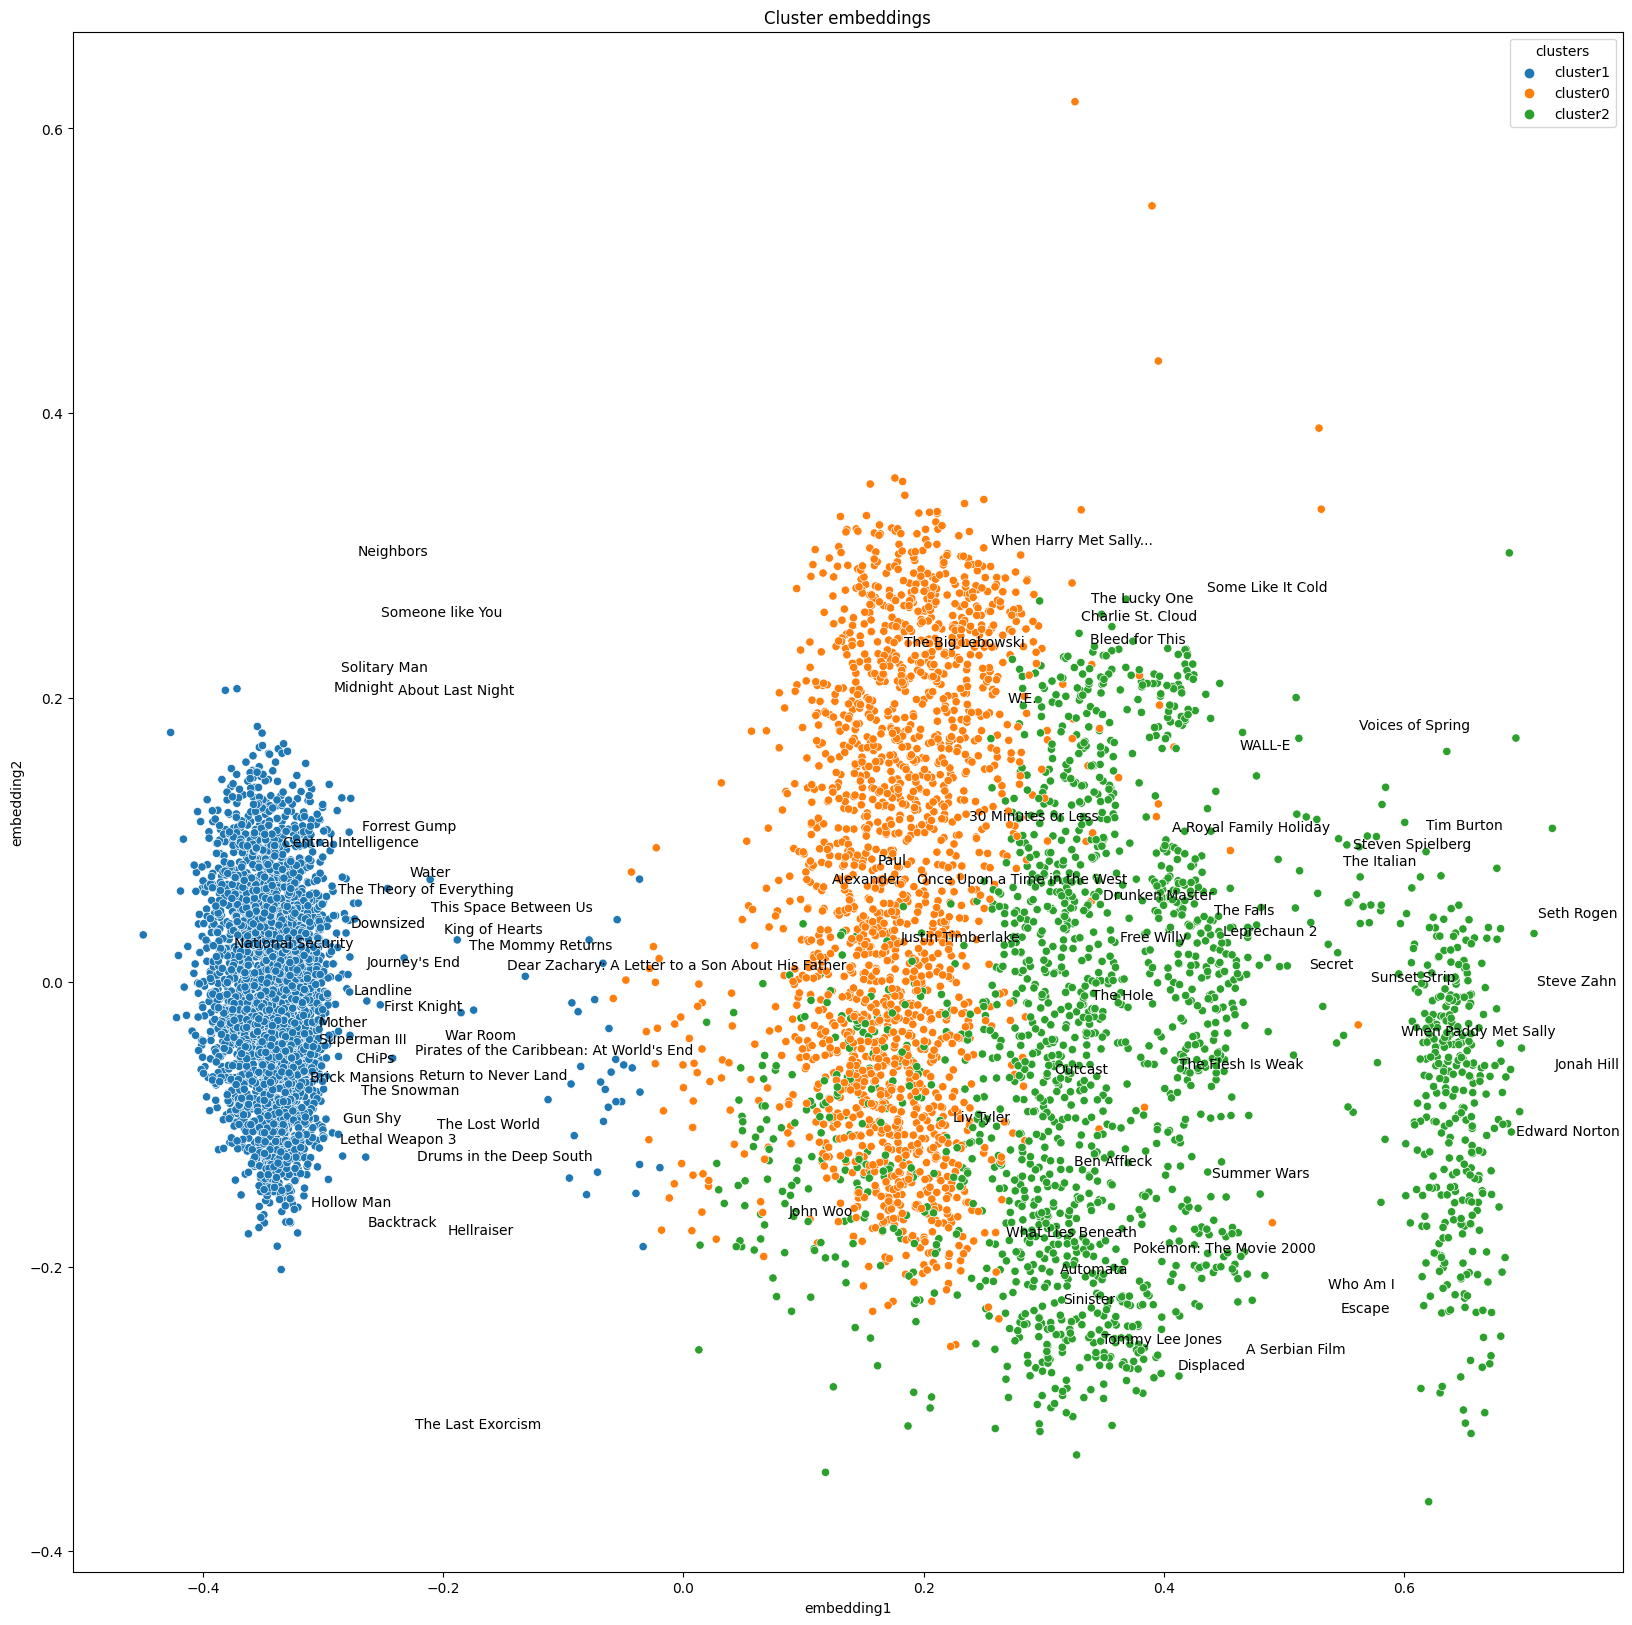

In [ ]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# Get the embeddings (150 dims) for all the entities of interest
jobs_embeddings = model.get_embeddings(all_entities, embedding_type='e')

# Perform PCA and reduce the dims to 2
embeddings_2d = PCA(n_components=2).fit_transform(np.array([emb for emb in jobs_embeddings]))

# Create a dataframe to plot the embeddings using scatterplot
df = pd.DataFrame({"entities": all_entities, "clusters": "cluster" + pd.Series(clusters).astype(str),
                    "embedding1": embeddings_2d[:, 0], "embedding2": embeddings_2d[:, 1]})

plt.figure(figsize=(20, 20))
plt.title("Cluster embeddings")

ax = sns.scatterplot(data=df, x="embedding1", y="embedding2", hue="clusters")

# Print only a few labels, to avoid clutter, using adjust_text
from adjustText import adjust_text
texts = []
for i, point in df.iterrows():
    # randomly choose a few labels to be printed
    if np.random.uniform() < 0.01:
        texts.append(plt.text(point['embedding1']+.1, point['embedding2'], str(point['entities'])))

adjust_text(texts)
plt.show()

## 7.3 Hypothesis Generation

Other times you may wish to discover **any** potential new facts from an existing knowledge graph. This can be done using [discover_facts](https://docs.ampligraph.org/en/1.4.0/generated/ampligraph.discovery.discover_facts.html#ampligraph.discovery.discover_facts) API.

With a knowledge graph containing millions of entities the space of possible facts is huge, and evaluating all of them can take a very long time. In order to speed up this task we have implemented a number of sampling strategies.

The strategies implemented include:
>    ```entity_frequency```, ```graph_degree```, ```cluster_coefficient```, ```cluster_triangles```, ```cluster_squares```, ```random_uniform```, ```exhaustive```.

Entities in all strategies excluding ```random_uniform```, ```exhaustive``` are sorted in ascending fashion, on the assumption that frequent or densely connected entities are less likely to have missing true statements.

The general procedure is to generate a set of candidate statements, and then rank them against a set of corruptions using the ```model.evaluate()``` function.

A sampling weight is calculated for each entity using the specified strategy, and ```max_candidates``` are sampled to produce the candidate triple set.

Candidates are then evaluated to obtain a rank, and triples that appear in the ```top_n``` ranked statements of evaluation procedure are returned as potentially true statements.
            


In [ ]:
from ampligraph.discovery import discover_facts

triples, ranks = discover_facts(dataset.values,
                                model,
                                top_n=500,
                                max_candidates=500,
                                strategy='cluster_triangles',
                                target_rel='HAS_DIRECTOR',
                                seed=0)

for triple, rank in zip(triples, ranks):
    print('Rank: {} \t {} '.format(rank, triple))


## 7.4 Duplicate detection

KGE models can be used for entity disambiguation. In the graph you may have multiple labels for same concept. Eg. B Obama, Obama, Barak obama, Barak, Barak o, etc. All these labels identify the same person. You can find duplicate entities or relations in the graph by looking at the embedding space. Two entities which are very close in the embedding space (can be specified as a hyperparameter) can be considered as duplicates. AmpliGraph provides the ``find_duplicates`` API to get the duplicates.

In [ ]:
import pandas as pd
import numpy as np
import re

# The IMDB dataset used here is part of the Movies5 dataset found on:
# The Magellan Data Repository (https://sites.google.com/site/anhaidgroup/projects/data)
import requests
url = 'http://pages.cs.wisc.edu/~anhai/data/784_data/movies5.tar.gz'
open('movies5.tar.gz', 'wb').write(requests.get(url).content)
import tarfile
tar = tarfile.open('movies5.tar.gz', "r:gz")
tar.extractall()
tar.close()

# Reading tabular dataset of IMDB movies and filling the missing values
imdb = pd.read_csv("movies5/csv_files/imdb.csv")
imdb["directors"] = imdb["directors"].fillna("UnknownDirector")
imdb["actors"] = imdb["actors"].fillna("UnknownActor")
imdb["genre"] = imdb["genre"].fillna("UnknownGenre")
imdb["duration"] = imdb["duration"].fillna("0")

# Creating knowledge graph triples from tabular dataset
imdb_triples = []

for _, row in imdb.iterrows():
    movie_id = "ID" + str(row["id"])
    directors = row["directors"].split(",")
    actors = row["actors"].split(",")
    genres = row["genre"].split(",")
    duration = "Duration" + str(int(re.sub("\D", "", row["duration"])) // 30)

    directors_triples = [(movie_id, "hasDirector", d) for d in directors]
    actors_triples = [(movie_id, "hasActor", a) for a in actors]
    genres_triples = [(movie_id, "hasGenre", g) for g in genres]
    duration_triple = (movie_id, "hasDuration", duration)

    imdb_triples.extend(directors_triples)
    imdb_triples.extend(actors_triples)
    imdb_triples.extend(genres_triples)
    imdb_triples.append(duration_triple)


imdb_triples = np.array(imdb_triples)

model = ScoringBasedEmbeddingModel(k=150,                                         # embedding size
                                   eta=5,                                         # number of corruptions to generate during training
                                   scoring_type='ComplEx',                         # Scoring Function name
                                   seed=0)                                        # Random generator seed

optim = tf.keras.optimizers.Adam(learning_rate=0.001)

# compile the model with loss and optimizer
model.compile(optimizer=optim,
              loss='multiclass_nll',
              entity_relation_initializer='glorot_normal',
              entity_relation_regularizer='L2')

model.fit(imdb_triples, epochs=200, batch_size=1000)

from ampligraph.discovery import find_duplicates
entities = np.unique(imdb_triples[:, 0])
dups, _ = find_duplicates(entities, model, mode='e', tolerance=0.4)


Epoch 1/200
54/54 [==============================] - 3s 50ms/step - loss: 1768.3258
Epoch 2/200
54/54 [==============================] - 0s 9ms/step - loss: 1767.9297
Epoch 3/200
54/54 [==============================] - 0s 9ms/step - loss: 1767.7880
Epoch 4/200
54/54 [==============================] - 1s 11ms/step - loss: 1767.7103
Epoch 5/200
54/54 [==============================] - 1s 11ms/step - loss: 1767.6637
Epoch 6/200
54/54 [==============================] - 1s 11ms/step - loss: 1767.6328
Epoch 7/200
54/54 [==============================] - 0s 9ms/step - loss: 1767.5913
Epoch 8/200
54/54 [==============================] - 0s 9ms/step - loss: 1767.4241
Epoch 9/200
54/54 [==============================] - 0s 9ms/step - loss: 1766.8807
Epoch 10/200
54/54 [==============================] - 0s 9ms/step - loss: 1765.5199
Epoch 11/200
54/54 [==============================] - 0s 9ms/step - loss: 1762.7539
Epoch 12/200
54/54 [==============================] - 0s 9ms/step - loss: 1758.02

In [ ]:
print(list(dups)[:3])

print(imdb[imdb.id.isin((1101, 1102, 2523, 2522, 4359, 4360))][['movie_name', 'year']])


[frozenset({'ID64', 'ID882', 'ID1862', 'ID1136', 'ID365', 'ID926', 'ID2376', 'ID6704', 'ID186', 'ID1789', 'ID6092', 'ID758', 'ID3121', 'ID4735', 'ID6584', 'ID1636', 'ID2162', 'ID1512', 'ID4484', 'ID1297', 'ID871', 'ID1607', 'ID1532', 'ID4836', 'ID971', 'ID6273', 'ID2007', 'ID1122', 'ID3896', 'ID1985', 'ID3585', 'ID4753', 'ID992', 'ID2996', 'ID583', 'ID4870', 'ID3706', 'ID2803', 'ID5185', 'ID580', 'ID6608', 'ID5183', 'ID1106', 'ID4117', 'ID629', 'ID5520', 'ID1922', 'ID1846', 'ID1010', 'ID2817', 'ID3901', 'ID4533', 'ID4902', 'ID1573', 'ID1980', 'ID38', 'ID4690', 'ID4746', 'ID1305', 'ID763', 'ID813', 'ID6738', 'ID6394', 'ID1794', 'ID1653', 'ID2393', 'ID2023', 'ID3931', 'ID6247', 'ID806', 'ID4900', 'ID499', 'ID3132', 'ID6749', 'ID1218', 'ID126', 'ID3971', 'ID6661', 'ID395', 'ID5187', 'ID6852', 'ID3674', 'ID4211', 'ID803', 'ID3147', 'ID2288', 'ID2526', 'ID6266', 'ID6636', 'ID6699', 'ID2233', 'ID6145', 'ID1206', 'ID3825', 'ID670', 'ID2973', 'ID2824', 'ID1014', 'ID4992', 'ID6736', 'ID166', 'I

## 8. Query Embedding


**BERT in Text Embedding:**

1. **Bidirectional Context Understanding:**
   - BERT captures bidirectional context, considering both left and right context for a more comprehensive understanding.

2. **Tokenization and Embeddings:**
   - BERT tokenizes text and converts it into embeddings, capturing contextual information for each word.

3. **Contextualized Word Representations:**
   - BERT generates contextualized word representations, influenced by relationships with surrounding words in the entire sentence.

4. **Self-Attention Mechanism:**
   - BERT uses a self-attention mechanism to dynamically assign importance to words, capturing long-range dependencies.

5. **Pre-training on Large Corpus:**
   - Pre-training on a massive corpus equips BERT with a rich understanding of language nuances.

6. **Transfer Learning for Downstream Tasks:**
   - BERT's pre-trained embeddings facilitate effective adaptation to various natural language processing tasks.

**Applications:**
   - BERT's advanced embeddings find use in tasks like sentiment analysis, named entity recognition, and text summarization, owing to its bidirectional context understanding and transfer learning capabilities.

In [ ]:
!pip install transformers
!pip install torch

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Sample text
text = "BERT is a powerful model for natural language processing tasks."

# Tokenize and encode the text
tokens = tokenizer(text, return_tensors='pt')

# Get BERT embeddings
with torch.no_grad():
    outputs = model(**tokens)

# Extract embeddings from the last layer
last_hidden_states = outputs.last_hidden_state

# Average pooling to get a single embedding for the entire sentence
sentence_embedding = torch.mean(last_hidden_states, dim=1)

# Print the resulting embedding
print(sentence_embedding)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tensor([[-2.5680e-01, -3.3541e-01,  3.5745e-02, -1.6995e-01, -1.2164e-01,
         -2.4259e-01,  5.1590e-03, -1.4583e-02, -3.4132e-02,  5.4135e-02,
          1.8577e-01,  5.8672e-02, -1.9209e-01, -1.5262e-03, -1.3239e-01,
          1.3764e-01, -2.2234e-01,  2.5420e-01, -1.8036e-01, -1.0990e-01,
          6.7581e-02,  7.6373e-02, -1.0542e-01,  8.8645e-02,  3.3429e-01,
         -2.6443e-01, -9.6855e-02, -9.9871e-02, -4.7227e-01, -7.8423e-02,
         -2.3179e-01,  5.0023e-01, -6.4586e-02, -2.7195e-01, -2.6329e-01,
          3.4465e-01, -2.0793e-02, -1.4706e-01, -2.0816e-01,  2.8993e-01,
         -3.8175e-01, -3.7497e-01, -2.4623e-01,  1.0372e-01, -9.7825e-02,
         -2.6507e-01, -2.0131e-01, -1.1015e-02,  3.5903e-01, -2.6861e-01,
         -1.3060e+00,  4.5197e-01, -2.1898e-01,  1.3938e-01,  7.0226e-02,
          4.7193e-01,  1.6662e-01, -8.4806e-01,  3.9093e-01, -1.0531e-01,
         -1.6031e-02,  1.3648e-01, -2.2562e-01, -7.6365e-01,  4.6136e-01,
          1.1039e-01, -3.0893e-01,  9.